In [204]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
%pylab inline
#import choroplethNYC as cp
try:
    import urllib2
except ImportError:
    import urllib
import os
import requests
import json
import sys
import io
import shapely
from fiona.crs import from_epsg
from functools import reduce
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [4]:
#make PUIDATA an environment variable
os.environ["PUIDATA"] = "%s/PUIData"%os.getenv("HOME")

In [5]:
#change working directory to PUIDATA
os.chdir(os.getenv("PUIDATA"))
os.getcwd()

'/nfshome/mrn291/PUIData'

### 1 Download park inspection data¶

In [16]:
#download data from open data using the open data API
parks_download = 'https://data.cityofnewyork.us/resource/a5vb-ya4e.json'

parks_data = pd.read_json(parks_download)

parks_data.head()

,ampsdistrict,begininspection,cleanliness,closed,comments,date,endinspection,inspaddeddate,inspection_id,inspection_year,inspectiontype,inspector,inspector2,overall_condition,prop_id,round,safety_condition,season,structural_condition,visitorcount
0,1.0,12:30 PM,A,Under Construction.,"Site closed for bridge maintenance, exterior r...",2010-05-24,12:46 PM,2010-05-24 14:40:00,68214,2010,PIP,3,NULL,A,Q066A,1,NaN,Summer,NaN,NULL
1,4.0,11:45 AM,A,NULL,NULL,2010-05-24,11:55 AM,2010-05-24 14:56:00,68220,2010,PIP,15,NULL,A,QZ284,1,NULL,Summer,NULL,NULL
2,12.0,11:05 AM,A,NULL,NULL,2010-05-24,11:35 AM,2010-05-24 15:23:00,68227,2010,PIP,18,NULL,A,Q121A,1,NULL,Summer,NULL,NULL
3,12.0,10:20 AM,U,NULL,NULL,2010-05-24,10:54 AM,2010-05-24 15:37:00,68228,2010,PIP,18,NULL,U,Q301,1,NULL,Summer,NULL,NULL
4,3.0,09:25 AM,A,Partial Constr./Rest of Site Rated.,Most of park closed for school repair.,2010-05-25,09:37 AM,2010-05-25 12:07:00,68234,2010,PIP,6,NULL,A,M196,1,NULL,Summer,NULL,NULL


In [11]:
#look at column names
list(parks_data.columns)

['ampsdistrict',
 'begininspection',
 'cleanliness',
 'closed',
 'comments',
 'date',
 'endinspection',
 'inspaddeddate',
 'inspection_id',
 'inspection_year',
 'inspectiontype',
 'inspector',
 'inspector2',
 'overall_condition',
 'prop_id',
 'round',
 'safety_condition',
 'season',
 'structural_condition',
 'visitorcount']

In [12]:
#look at data types
parks_data.dtypes

ampsdistrict                   float64
begininspection                 object
cleanliness                     object
closed                          object
comments                        object
date                    datetime64[ns]
endinspection                   object
inspaddeddate                   object
inspection_id                    int64
inspection_year                  int64
inspectiontype                  object
inspector                        int64
inspector2                      object
overall_condition               object
prop_id                         object
round                            int64
safety_condition                object
season                          object
structural_condition            object
visitorcount                    object
dtype: object

In [17]:
#what the heck are the overall conditions if not already numeric??
parks_data.groupby('overall_condition').count()

,ampsdistrict,begininspection,cleanliness,closed,comments,date,endinspection,inspaddeddate,inspection_id,inspection_year,inspectiontype,inspector,inspector2,prop_id,round,safety_condition,season,structural_condition,visitorcount
overall_condition,,,,,,,,,,,,,,,,,,,
A,754,801,801,617,622,801,801,801,801,801,801,801,801,801,801,602,801,602,801
N,53,63,63,56,55,63,63,63,63,63,63,63,63,63,63,54,63,54,63
U,135,136,136,91,93,136,136,136,136,136,136,136,136,136,136,87,136,87,136


In [70]:
#make up a numerical value for each of the overall condition categories???
# per data dictionary A= acceptable; U= unacceptable; N= not rated
ratings = {'A':1, 'U':-1, 'N':0}
parks_data['overall_condition_numeric'] = parks_data['overall_condition'].map(ratings)

In [71]:
#Group the dataframe by park park id and get the mean condition for each park.
parksinspection = parks_data.groupby(['prop_id'])['overall_condition_numeric'].mean().reset_index()

parksinspection.head()

,prop_id,overall_condition_numeric
0,B007,-0.5
1,B008,1.0
2,B008-03,1.0
3,B012,1.0
4,B012-02,1.0


### 2. Download parks shapefile for the NYC Open Data data.

In [72]:
#Download parks shapefile for the NYC Open Data data.
park_shape_url = 'https://data.cityofnewyork.us/api/geospatial/k2ya-ucmv?method=export&format=Shapefile'
urllib.request.urlretrieve(park_shape_url, "park_shapes.gz")
!unzip -d $PUIDATA park_shapes.gz

Archive:  park_shapes.gz
  inflating: /nfshome/mrn291/PUIData/geo_export_e821e6e2-8ad0-441e-8c93-48ea5cf19708.dbf  
  inflating: /nfshome/mrn291/PUIData/geo_export_e821e6e2-8ad0-441e-8c93-48ea5cf19708.shp  
  inflating: /nfshome/mrn291/PUIData/geo_export_e821e6e2-8ad0-441e-8c93-48ea5cf19708.shx  
  inflating: /nfshome/mrn291/PUIData/geo_export_e821e6e2-8ad0-441e-8c93-48ea5cf19708.prj  


In [73]:
shapefile = 'geo_export_57464f41-b7f8-403a-8029-05b3cb8be009.shp'
park_shapes = gpd.GeoDataFrame.from_file(shapefile)

In [74]:
park_shapes.head()

,acquisitio,acres,address,borough,class,commission,communityb,councildis,department,eapply,...,precinct,retired,signname,subcategor,typecatego,url,us_congres,waterfront,zipcode,geometry
0,19440801000000.00000,0.991,None,M,PLGD,20100106000000.00000,111,9,M-11,Abraham Lincoln Playground,...,25,False,Abraham Lincoln Playground,Neighborhood Plgd,Community Park,http://www.nycgovparks.org/parks/M193/,13,No,10037,POLYGON ((-73.93682693707335 40.81184552631012...
1,None,0.030,None,Q,PARK,20090423000000.00000,413,23,Q-13,Father Reilly Square,...,105,False,Father Reilly Square,Sitting Area/Triangle/Mall,Triangle/Plaza,http://www.nycgovparks.org/parks/Q159/,5,No,11428,POLYGON ((-73.73628053979716 40.72267578865961...
2,19360824000000.00000,0.911,2300 Ryer Avenue,X,PARK,20100106000000.00000,205,15,X-05,Slattery Playground,...,46,False,Slattery Playground,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/X085/,15,No,10458,POLYGON ((-73.89825077067158 40.85693358482933...
3,19520206000000.00000,0.189,349 RODNEY STREET,B,PARK,20100106000000.00000,301,34,B-01,Rodney Playground Center,...,90,False,Rodney Playground Center,Sitting Area/Triangle/Mall,Neighborhood Park,http://www.nycgovparks.org/parks/B223PD/,7,No,11211,POLYGON ((-73.95533291494969 40.71042213200856...
4,19240403000000.00000,0.554,124 11 STREET,B,PARK,20110712000000.00000,306,39,B-06,Ennis Playground,...,78,False,Ennis Playground,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/B095/,7,No,11215,POLYGON ((-73.99424820391394 40.67057586455565...


In [75]:
park_shapes.shape

(2007, 36)

In [76]:
park_shapes.columns

Index(['acquisitio', 'acres', 'address', 'borough', 'class', 'commission',
       'communityb', 'councildis', 'department', 'eapply', 'gisobjid',
       'gispropnum', 'global_id', 'jurisdicti', 'location', 'mapped',
       'name311', 'nys_assemb', 'nys_senate', 'objectid', 'omppropid',
       'parentid', 'permit', 'permitdist', 'permitpare', 'pip_ratabl',
       'precinct', 'retired', 'signname', 'subcategor', 'typecatego', 'url',
       'us_congres', 'waterfront', 'zipcode', 'geometry'],
      dtype='object')

# I KNOW THIS MERGE IS TOTALLY F'ED--SHOULD BE MORE PARKS.  BUT RAN OUT OF TIME TO FIND OUT WHAT WAS WRONG

In [82]:
#Extract the Brooklyn park properties from this file and merge it with the inspection data. 
bk_parks = park_shapes[park_shapes['borough']=='B']
bk_parks_inspected = pd.merge(bk_parks, parksinspection, how='inner', left_on='gispropnum', right_on = 'prop_id')
bk_parks.shape


(608, 36)

In [87]:
bk_parks_inspected.columns

Index(['acquisitio', 'acres', 'address', 'borough', 'class', 'commission',
       'communityb', 'councildis', 'department', 'eapply', 'gisobjid',
       'gispropnum', 'global_id', 'jurisdicti', 'location', 'mapped',
       'name311', 'nys_assemb', 'nys_senate', 'objectid', 'omppropid',
       'parentid', 'permit', 'permitdist', 'permitpare', 'pip_ratabl',
       'precinct', 'retired', 'signname', 'subcategor', 'typecatego', 'url',
       'us_congres', 'waterfront', 'zipcode', 'geometry', 'prop_id',
       'overall_condition_numeric'],
      dtype='object')

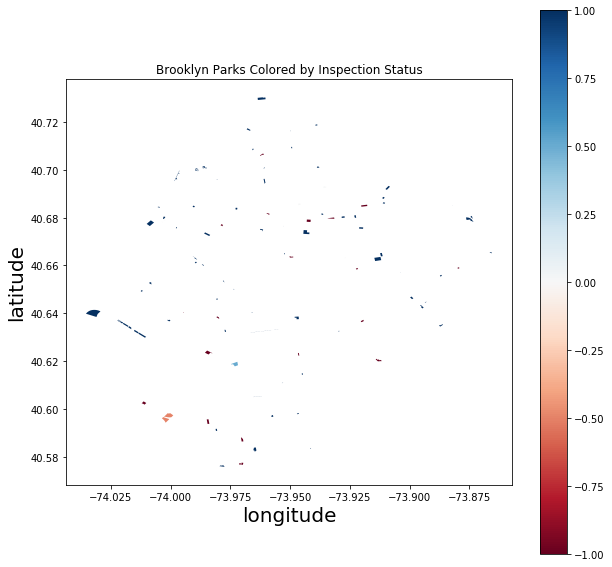

In [92]:
#plot the parks colorcoded by condition.
ax = bk_parks_inspected.plot(column="overall_condition_numeric", k=3, cmap="RdBu", legend=True, figsize=(10,10))
plt.title("Brooklyn Parks Colored by Inspection Status")
ax.set_ylabel("latitude", fontsize=20)
ax.set_xlabel("longitude", fontsize=20);
#im = ax.imshow(puma_broadband['BB_Percent'], cmap='viridis')
#cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im, ax=ax)
plt.show()

Figure showing the average inspection result for Brooklyn Parks where Red is a higher average inspection value and blue is a lower average inspection value

### 3 Download unemployment rate information from ACS 2015 (5 year survey) for Brooklyn at the PUMA geographical aggregation level.

In [248]:
#add cwd to system path in order have it look up the census API file
os.chdir('/nfshome/mrn291/PUI2018_mrn291')

#add cwd to system path in order have it look up the census API file
sys.path.append(os.getcwd())
from censusAPI import myAPI

#NOTE YOU NEED TO HAVE A FILE IN YOUR DIRECTORY WITH myAPI = 'YOUR CENSUS API KEY'
# ALSO I KNOW YOU'RE SUPPOSED TO DO ALL YOUR IMPORTS UP TOP BUT I DIDN'T WANT TO CHANGE ALL MY DIRECTORIES AROUND AGAIN

In [138]:
unemployed_males_17_64 = 'C23002G_008E'

unemployed_females_17_64 = 'C23002G_021E'

total_surveyed_population_17_64 = 'C23002G_001E'

total_population = 'B00001_001E'

all_variables = [unemployed_males_17_64, unemployed_females_17_64, total_surveyed_population_17_64, total_population]

frames = []

for variable in all_variables:
    url = "https://api.census.gov/data/2015/acs/acs5?get=" + variable +\
    ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
    resp = requests.request('GET', url).content
    puma_pop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
    frames.append(puma_pop)

In [140]:
pumaUnemployment = reduce(lambda left,right: pd.merge(left,right,on=['NAME','public use microdata area','state']), frames)

In [141]:
pumaUnemployment.drop(['Unnamed: 4_x', 'Unnamed: 4_y', 'Unnamed: 4'], axis=1, inplace=True)
pumaUnemployment.rename(columns={'public use microdata area':'PUMA', 'C23002G_008E': 'unemployed_males_17_64', 'C23002G_021E':'unemployed_females_17_64', 'C23002G_001E':'total_surveyed_population_17_64', 'B00001_001E':'total_pop'}, inplace=True)

In [142]:
pumaUnemployment.head()

,unemployed_males_17_64,NAME,state,PUMA,unemployed_females_17_64,total_surveyed_population_17_64,total_pop
0,75,"St. Lawrence County PUMA, New York",36,100,79,1304,15725
1,141,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,74,1782,23140
2,50,"Warren & Washington Counties PUMA, New York",36,300,42,1066,14491
3,62,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,23,724,14933
4,83,Oneida County (Central)--Greater Utica & Rome ...,36,402,124,2476,15492


In [143]:
puma_sums = pumaUnemployment.groupby('PUMA').sum().reset_index()

In [144]:
puma_sums.head()

,PUMA,unemployed_males_17_64,state,unemployed_females_17_64,total_surveyed_population_17_64,total_pop
0,100,75,36,79,1304,15725
1,200,141,36,74,1782,23140
2,300,50,36,42,1066,14491
3,401,62,36,23,724,14933
4,402,83,36,124,2476,15492


In [145]:
puma_sums['total_unemployed'] = puma_sums['unemployed_males_17_64'] + puma_sums['unemployed_females_17_64']

In [149]:
puma_sums['percent_unemployed'] = ((puma_sums.total_unemployed.astype(float)) / puma_sums.total_pop) * 100

In [151]:
puma_sums[['PUMA', 'total_pop', 'percent_unemployed']].head()

,PUMA,total_pop,percent_unemployed
0,100,15725,0.979332
1,200,23140,0.929127
2,300,14491,0.634877
3,401,14933,0.569209
4,402,15492,1.336174


### 4 Obtain the PUMA spatial file

In [153]:
os.chdir(os.getenv("PUIDATA"))
puma_url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(puma_url, "puma.gz")
!unzip -d $PUIDATA puma.gz

Archive:  puma.gz
  inflating: /nfshome/mrn291/PUIData/geo_export_e30eaffa-2f49-48b0-83d8-178f95d8bd47.dbf  
  inflating: /nfshome/mrn291/PUIData/geo_export_e30eaffa-2f49-48b0-83d8-178f95d8bd47.shp  
  inflating: /nfshome/mrn291/PUIData/geo_export_e30eaffa-2f49-48b0-83d8-178f95d8bd47.shx  
  inflating: /nfshome/mrn291/PUIData/geo_export_e30eaffa-2f49-48b0-83d8-178f95d8bd47.prj  


In [155]:
puma_shapefile = 'geo_export_e30eaffa-2f49-48b0-83d8-178f95d8bd47.shp'
puma_shapes = gpd.GeoDataFrame.from_file(puma_shapefile)

In [172]:
puma_shapes['puma'] = puma_shapes['puma'].astype(int)
puma_shapes.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [173]:
bk_pumas = pumaUnemployment[pumaUnemployment.NAME.str.contains("Brooklyn")]

In [174]:
bk_pumas.head()

,unemployed_males_17_64,NAME,state,PUMA,unemployed_females_17_64,total_surveyed_population_17_64,total_pop
113,85,NYC-Brooklyn Community District 1--Greenpoint ...,36,4001,139,2896,11560
114,149,NYC-Brooklyn Community District 4--Bushwick PU...,36,4002,171,3420,9103
115,97,NYC-Brooklyn Community District 3--Bedford-Stu...,36,4003,146,2422,10046
116,110,NYC-Brooklyn Community District 2--Brooklyn He...,36,4004,164,3571,11188
117,154,"NYC-Brooklyn Community District 6--Park Slope,...",36,4005,66,3100,9244


In [175]:
bk_puma_shape = pd.merge(puma_shapes, bk_pumas, left_on = 'puma', right_on = 'PUMA')

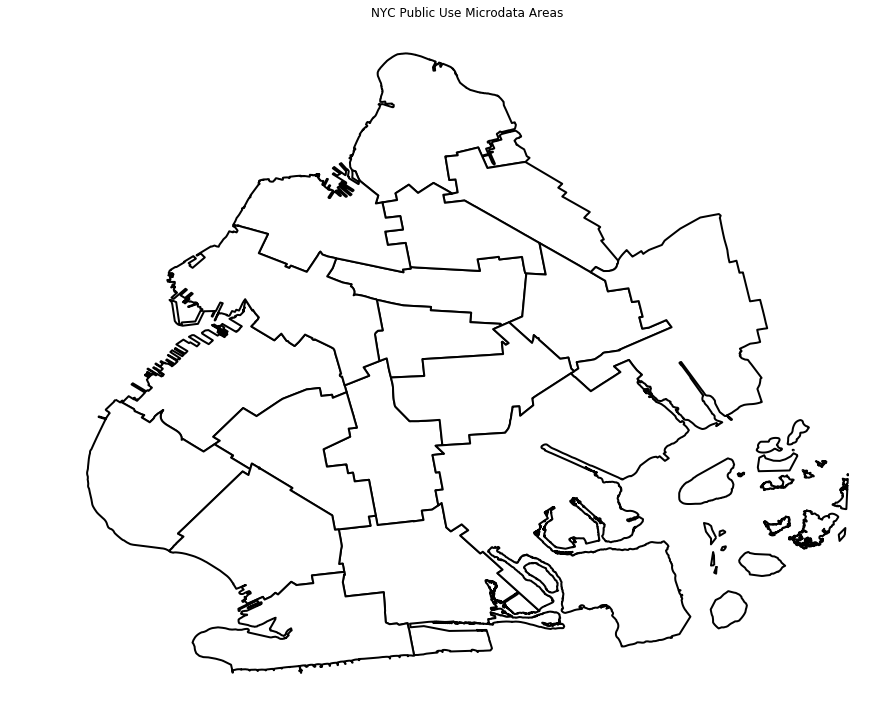

In [178]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("NYC Public Use Microdata Areas")
bk_puma_shape.plot(ax=ax, color='white', edgecolor='black', lw=2)
plt.show()

Figure showing the public use microdistrict areas of Brooklyn

# 5

In [179]:
url = 'https://serv.cusp.nyu.edu/~fbianco/PUIdata/parkToPuma.csv'
park_to_puma = pd.read_csv(url)

In [180]:
park_to_puma.head()

,puma,condition,gispropnum
0,4001,0.633277,52
1,4002,0.456086,17
2,4003,0.384951,23
3,4004,0.648573,49
4,4005,0.718519,29


## 6

In [239]:
skipping_url = 'https://serv.cusp.nyu.edu/~fbianco/PUIdata/parksFinal.csv'
final_data = pd.read_csv(skipping_url)
final_data.drop('geometry', axis=1, inplace=True)
final_data = bk_puma_shape.merge(final_data, on='puma')

In [240]:
final_data.crs = from_epsg(4326)

In [241]:
final_data.head()

,puma,shape_area,shape_leng,geometry,unemployed_males_17_64,NAME,state,PUMA,unemployed_females_17_64,total_surveyed_population_17_64,total_pop,Unnamed: 0,unemployedF,condition,parkcount
0,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,69,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,166,2235,12580,0,0.105145,0.783784,9
1,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,57,NYC-Brooklyn Community District 15--Sheepshead...,36,4016,15,1292,13774,1,0.055728,0.636923,18
2,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,73,NYC-Brooklyn Community District 8--Crown Heigh...,36,4006,98,2656,8913,2,0.064383,0.587387,15
3,4011,4.762886e+07,34965.040151,POLYGON ((-73.92828249221591 40.66144706650274...,30,NYC-Brooklyn Community District 9--Crown Heigh...,36,4011,64,1395,7389,3,0.067384,0.624242,8
4,4012,1.123044e+08,97261.951304,POLYGON ((-73.99684490483776 40.66903132477106...,0,NYC-Brooklyn Community District 7--Sunset Park...,36,4012,148,3031,11441,4,0.048829,0.516839,23


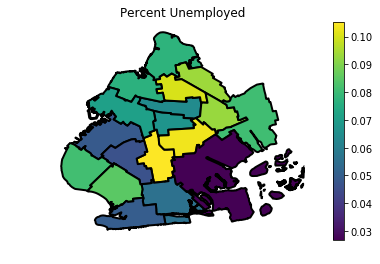

In [242]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
plt.title("Percent Unemployed")
final_data.plot(ax=ax, cmap='viridis', column='unemployedF', edgecolor='black', lw=2, legend=True)
plt.show()


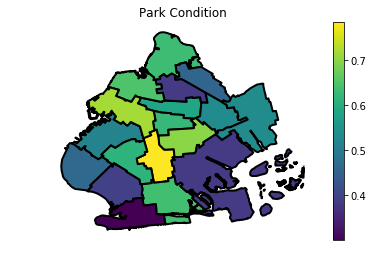

In [245]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
plt.title("Park Condition")
final_data.plot(ax=ax, cmap='viridis', column='condition', edgecolor='black', lw=2, legend=True)
plt.show()

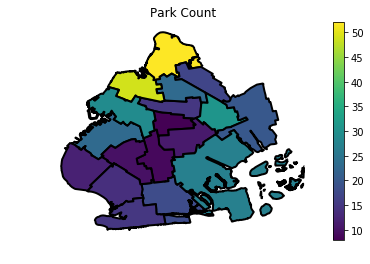

In [246]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
plt.title("Park Count")
final_data.plot(ax=ax, cmap='viridis', column='parkcount', edgecolor='black', lw=2, legend=True)
plt.show()

### 8

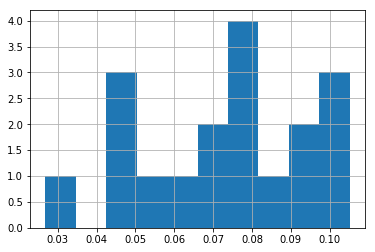

In [201]:
final_data['unemployedF'].hist()

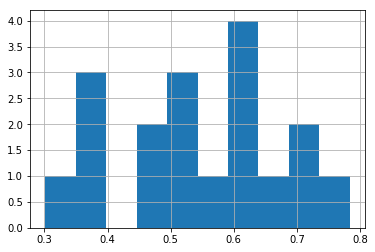

In [202]:
final_data['condition'].hist()

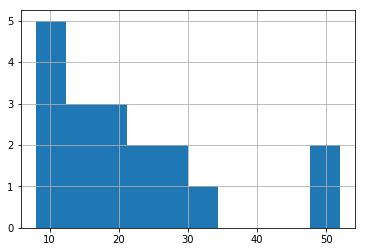

In [203]:
final_data['parkcount'].hist()

I ran out of time to run the test but from eyeballing, I'd say maybe unemployed is gaussian but the others aren't looking too gaussian-y on first glance.

#### 10. Measure correlation between parks condition and unemployment.  Your deliverable is a measure of correlation for each variable and an explanation of what they mean

In [206]:
scipy.stats.pearsonr(final_data.unemployedF, final_data.parkcount)

(-0.03845184142400597, 0.87959657055945695)

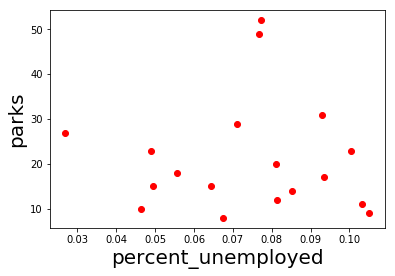

In [210]:
fig, ax = plt.subplots()
ax.set_xlabel("percent_unemployed", fontsize=20)
ax.set_ylabel("parks", fontsize=20)
plt.plot(final_data.unemployedF, final_data.parkcount, 'ro')

Figure showing pretty the relationship between the number of parks in a PUMA and the percent unemployed in that PUMA.  A Pearson's r statistic calculated for this relationship is -0.038, indicating a very slight negative relationship, but the alpha is .880 so we can't reject the null hypothesis that there is no relationship between the number of parks in the puma and the percent unemployed in the PUMA.

### 11. Test if the average park condition is significantly different for PUMAs with an unemployment fraction greater than 0.05 and lower then 0.05

Null hypothesis: the average park condition for PUMAs with unemployment fractions greater than or equal to 0.05 is the same as the average park condition for pumas with unemployment fractions less than 0.05.

alternative: the average park condition for PUMAs with unemployment fractions greater than or equal to 0.05 is greater than or less than the average park condition for pumas with unemployment fractions less than 0.05, but not equal to.

I'm adding the equal to condition since it's not mentioned in the question.

Alpha = 0.05

In [219]:
avg_over_fraction = final_data[final_data['unemployedF'] >= 0.05]
mean_over_fraction = avg_over_fraction.condition.mean()

In [220]:
avg_under_fraction = final_data[final_data['unemployedF'] < 0.05]
mean_under_fraction = avg_under_fraction.condition.mean()

In [222]:
print(mean_over_fraction, mean_under_fraction)

0.578375123965 0.454140545543


In [223]:
N = len(final_data)

In [227]:
sigma = np.std(avg_over_fraction['condition'])

In [229]:
Z = (mean_over_fraction - mean_under_fraction) / (sigma / np.sqrt(N))

In [231]:
print("The Z score is %f"%Z)

The Z score is 4.483750


#### The Z score is 2.6 which is greater than two standard deviations from the mean, which means that there is a less than 5% chance of randomly observing the new population mean, so we can reject the null hypothesis that there is no difference between the average park condition in PUMAs with high unemployement and PUMAs with low unemployment